# Credit Risk Assessment

As a data scientist at FinSecure Capital, your task is to build a machine learning model to assess borrower creditworthiness. You'll analyze borrower data like credit scores, income, and loan history to identify risk factors and predict the likelihood of default. The model will be integrated into the loan approval process, helping the company make informed lending decisions and reduce default rates.

**Objective**:  
Develop a machine learning model to assess borrower creditworthiness, predicting the likelihood of loan defaults to assist FinSecure Capital in making informed lending decisions.

**Scope**:  
- Utilize borrower data, including credit scores, employment history, income, debt-to-income ratio, and previous loan performance.
- Implement classification algorithms like logistic regression, random forests, or XGBoost.
- Ensure regulatory compliance and fairness in the model.
- Deploy the model for real-time credit scoring in the loan approval process.

**Target Metric Value**:  
Aim for an **AUC-ROC score of 0.85 or higher**, optimizing for a balance between precision and recall to reduce both false positives and false negatives in loan approvals.

In [1]:
!pip install -q autogluon==1.1.1

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.13.2 requires botocore<1.34.132,>=1.34.70, but you have botocore 1.29.165 which is incompatible.
albumentations 1.4.14 requires scikit-image>=0.21.0, but you have scikit-image 0.20.0 which is incompatible.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.2 which is incompatible.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you have pydantic 2.8.2 which is incompatible.
jupyterlab 4.2.4 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requires jupyter-ls

In [2]:
SEED = 22

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from autogluon.tabular import TabularDataset, TabularPredictor

np.random.seed(SEED)

In [71]:
ds = pd.read_csv('/kaggle/input/credit-risk-assessment/credit_risk_dataset.csv')

ds.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,35000,14.27,1,0.55,Y,4


In [72]:
print(ds.shape, ds.size)

(32581, 11) 358391


In [73]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_amnt                   32581 non-null  int64  
 6   loan_int_rate               29465 non-null  float64
 7   loan_status                 32581 non-null  int64  
 8   loan_percent_income         32581 non-null  float64
 9   cb_person_default_on_file   32581 non-null  object 
 10  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 2.7+ MB


In [74]:
ds.describe(include='all')

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,32581,31686.000000,32581,32581.000000,29465.000000,32581.000000,32581.000000,32581,32581.000000
unique,NaN,NaN,4,NaN,6,NaN,NaN,NaN,NaN,2,NaN
top,NaN,NaN,RENT,NaN,EDUCATION,NaN,NaN,NaN,NaN,N,NaN
freq,NaN,NaN,16446,NaN,6453,NaN,NaN,NaN,NaN,26836,NaN
mean,27.734600,6.607485e+04,NaN,4.789686,NaN,9589.371106,11.011695,0.218164,0.170203,NaN,5.804211
std,6.348078,6.198312e+04,NaN,4.142630,NaN,6322.086646,3.240459,0.413006,0.106782,NaN,4.055001
min,20.000000,4.000000e+03,NaN,0.000000,NaN,500.000000,5.420000,0.000000,0.000000,NaN,2.000000
25%,23.000000,3.850000e+04,NaN,2.000000,NaN,5000.000000,7.900000,0.000000,0.090000,NaN,3.000000
50%,26.000000,5.500000e+04,NaN,4.000000,NaN,8000.000000,10.990000,0.000000,0.150000,NaN,4.000000
75%,30.000000,7.920000e+04,NaN,7.000000,NaN,12200.000000,13.470000,0.000000,0.230000,NaN,8.000000


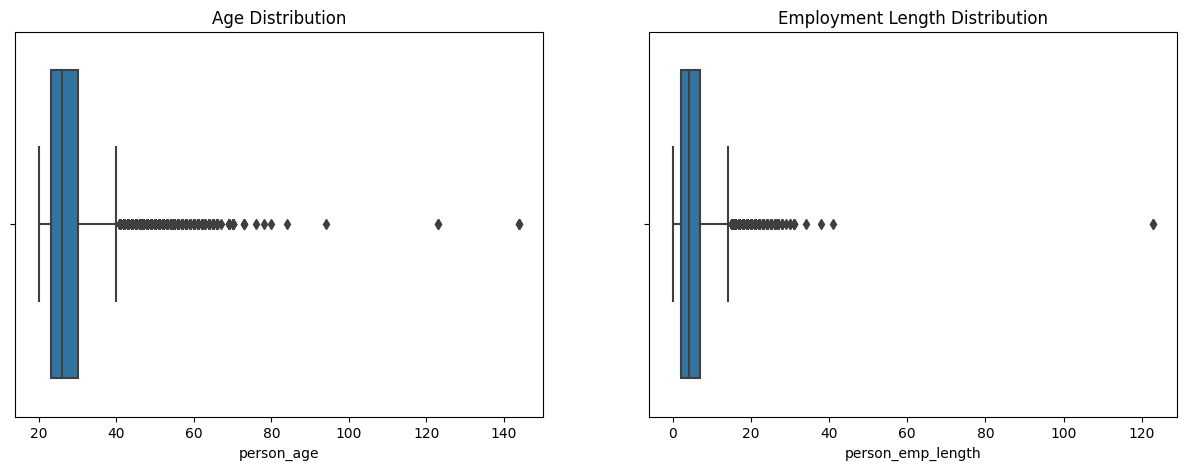

In [75]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.boxplot(data=ds, x='person_age', ax=ax1)
ax1.set_title('Age Distribution')

sns.boxplot(data=ds, x='person_emp_length', ax=ax2)
ax2.set_title('Employment Length Distribution')

plt.savefig('Outliers.png')
plt.show()

### Age and Employment Length Values

- Age has some extreme values > 60, even reaching 100+ which doesnt seem feasible
- Employment length also has values in the larger than 40, these seem like extreme outliers
- All extreme values will be removed

In [76]:
def remove_outliers(col, ds):
    '''
    Remove outliers from a column, using the inter-quartile range
    - calculate the upper limit and lower limit based on the IQR
    - filter out observations that fall out of range (< lower_limit or > upper_limit)
    '''
    if col == 'loan_status':
        return ds
   
    q1 = ds[col].quantile(0.25)
    q3 = ds[col].quantile(0.75)
    
    iqr = q3 - q1
    
    upper_limit = q3 + 1.5 * iqr
    lower_limit = q1 - 1.5 * iqr
    
    return ds.drop(ds[(ds[col] < lower_limit) | (ds[col] > upper_limit)].index)

In [77]:
num_cols = list(ds.select_dtypes(include='number').columns)

for col in num_cols:
    ds = remove_outliers(col, ds)

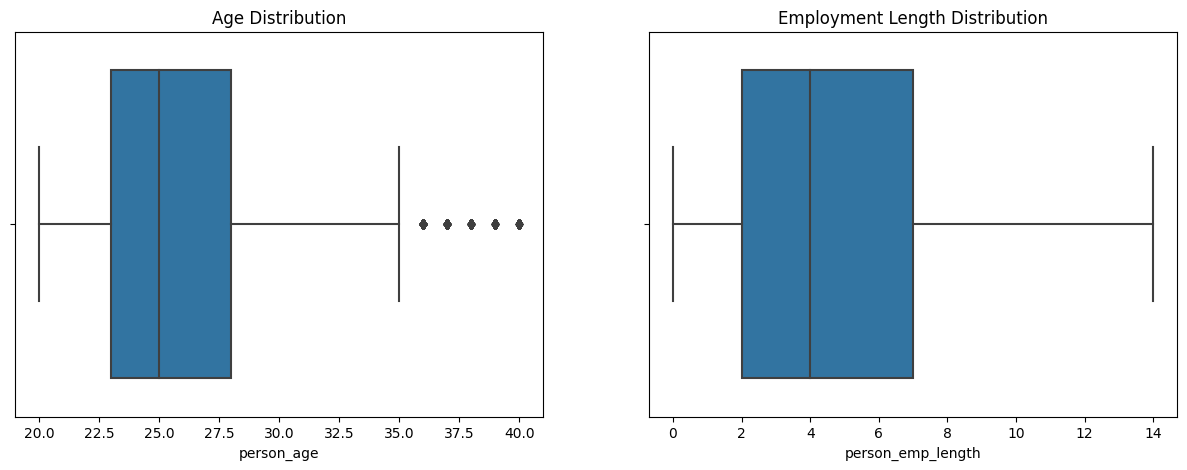

In [78]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.boxplot(data=ds, x='person_age', ax=ax1)
ax1.set_title('Age Distribution')

sns.boxplot(data=ds, x='person_emp_length', ax=ax2)
ax2.set_title('Employment Length Distribution')

plt.savefig('No_Outliers.png')
plt.show()

In [12]:
ds.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              762
loan_intent                      0
loan_amnt                        0
loan_int_rate                 2472
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [13]:
ds.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,21,9600,OWN,5.0,EDUCATION,1000,11.14,0,0.10,N,2
5,21,9900,OWN,2.0,VENTURE,2500,7.14,1,0.25,N,2
9,21,10000,OWN,6.0,VENTURE,1600,14.74,1,0.16,N,3
19,24,10800,MORTGAGE,8.0,EDUCATION,1750,10.99,1,0.16,N,2
23,24,10980,OWN,0.0,PERSONAL,1500,7.29,0,0.14,N,3


In [14]:
ds.shape

(26170, 11)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


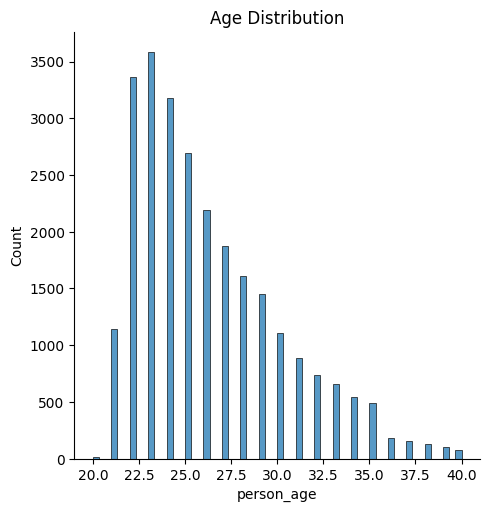

In [56]:
sns.displot(data=ds, x='person_age')
plt.title('Age Distribution')
plt.savefig('Age distribution.png')
plt.show()

### Age Of Loanees

- Majority of Loanees fall within the ages of 20 - 30

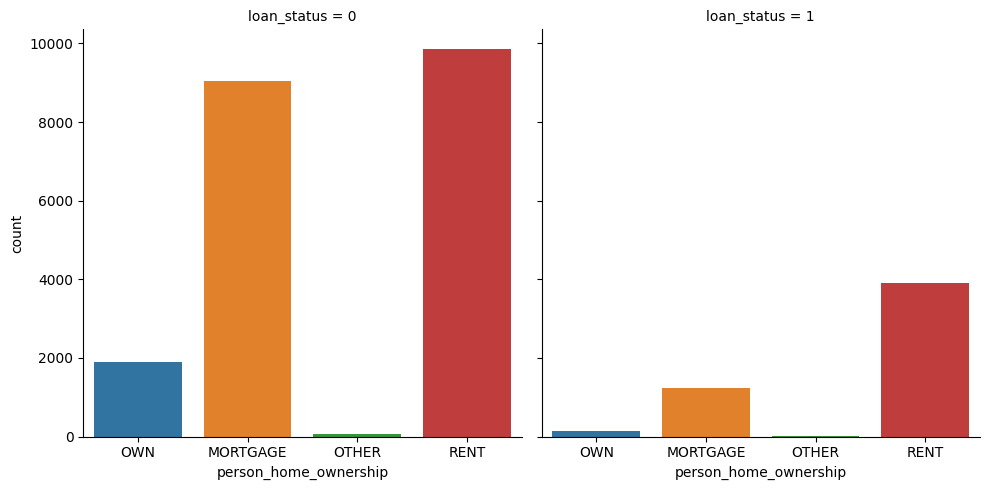

In [57]:
sns.catplot(data=ds, x='person_home_ownership', kind='count', col='loan_status')
plt.savefig('Home Ownership per loan status.png')
plt.show()

### Home Ownership Status

- Across all loan status categories, majority of loanees rent their current home

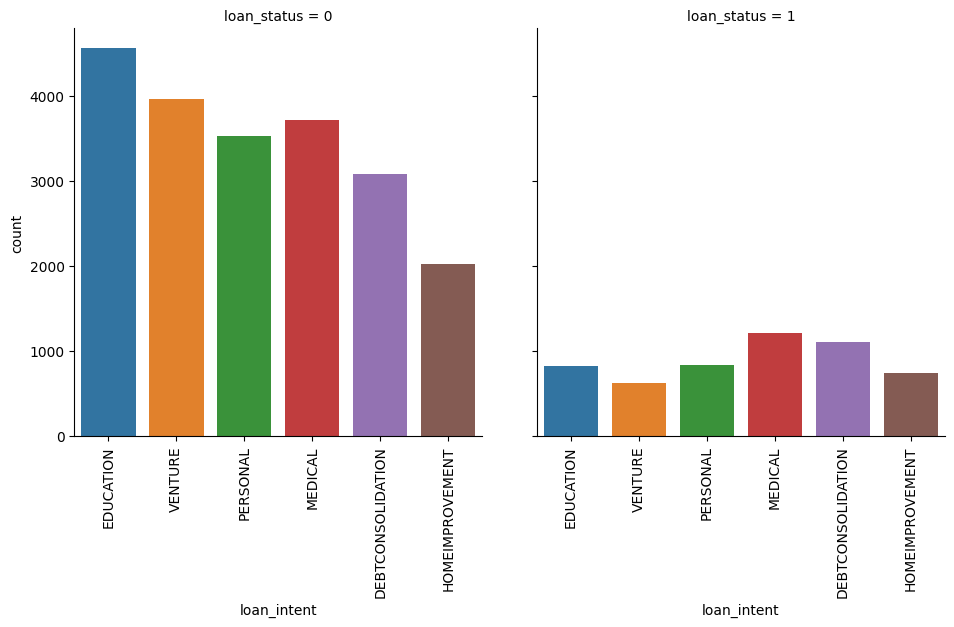

In [58]:
g = sns.catplot(data=ds, x='loan_intent', kind='count', col='loan_status')

for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    
plt.savefig('Loan Intent per Status.png')
plt.show()

### Loan Intent

Among loanees that did not default
- Education is the most popular reason for loans
- Followed by venture and medical reasons
- Home Improvement is the least popular reason

Among loanees that did default
- Medical reasons are the most popular reason
- Followed closely by debt consolidation and personal reasons

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


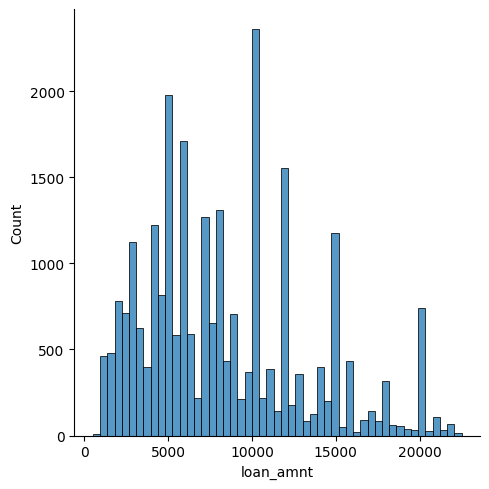

In [18]:
sns.displot(data=ds, x='loan_amnt')
plt.show()

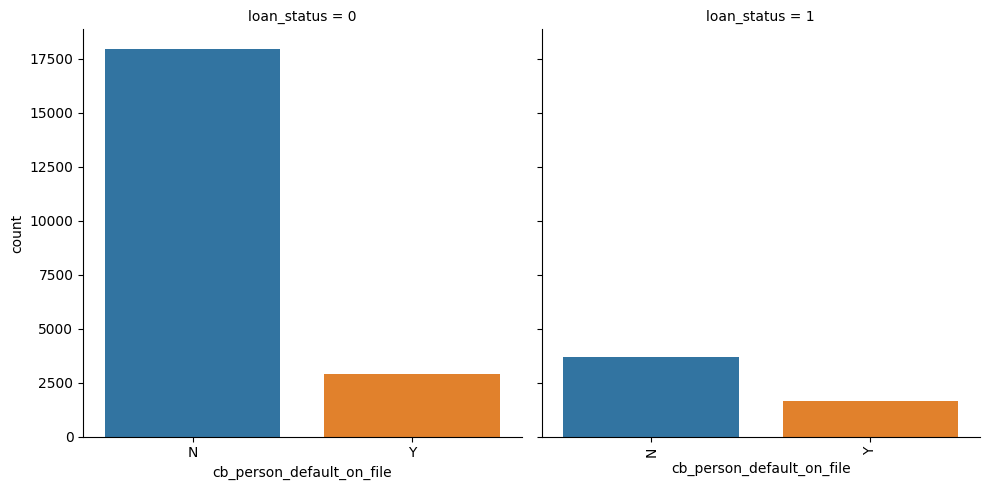

In [19]:
sns.catplot(data=ds, x='cb_person_default_on_file', kind='count', col='loan_status')
plt.xticks(rotation=90)
plt.show()

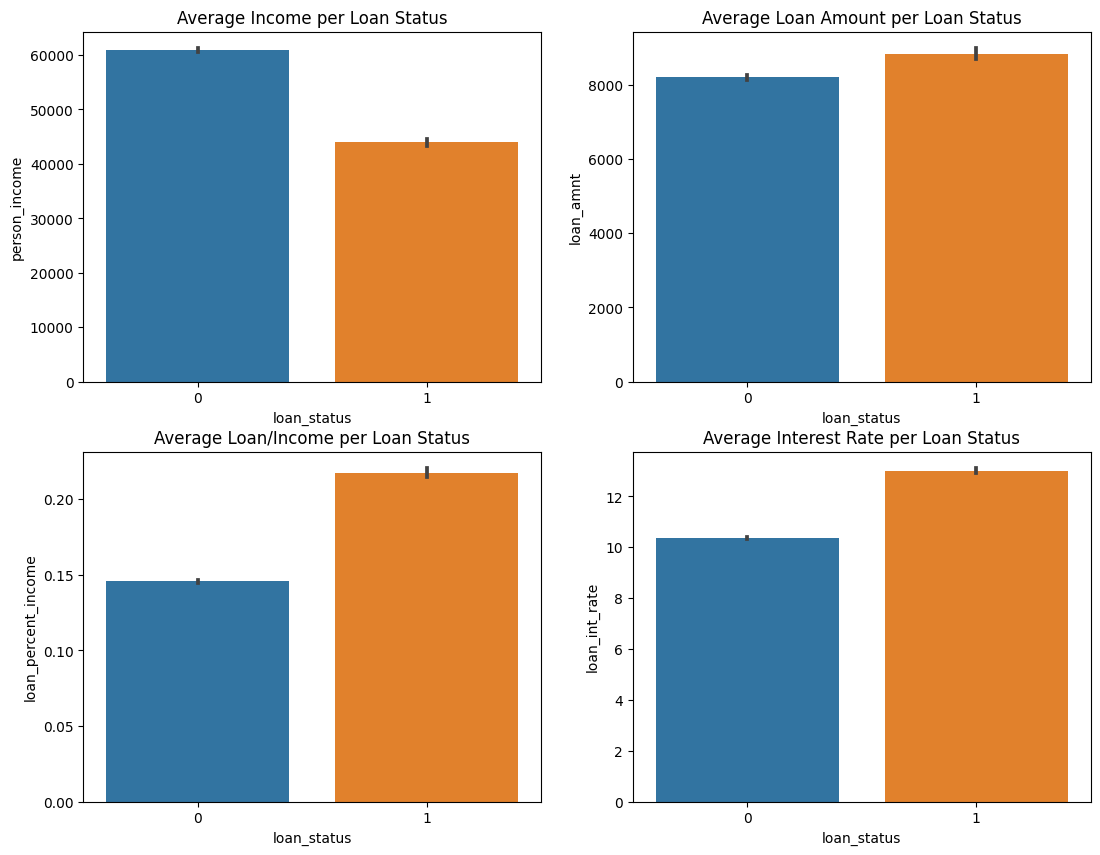

In [68]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13,10))

sns.barplot(data=ds, y='person_income', x='loan_status', ax=ax1)
ax1.set_title('Average Income per Loan Status')

sns.barplot(data=ds, y='loan_amnt', x='loan_status', ax=ax2)
ax2.set_title('Average Loan Amount per Loan Status')

sns.barplot(data=ds, y='loan_percent_income', x='loan_status', ax=ax3)
ax3.set_title('Average Loan/Income per Loan Status')

sns.barplot(data=ds, y='loan_int_rate', x='loan_status', ax=ax4)
ax4.set_title('Average Interest Rate per Loan Status')

plt.savefig('Income_LoanAmount_IncomePercent_Interest.png')
plt.show()

### Income

- The average income for loan defaulters is much lower than the average income for non defaulters.

### Loan Amount

- On average, defaulters take out larger loans than non-defaulters

### Percentage Of Income

- On average, defaulters take up loans that cover a larger percentage of their income than non-defaulters

### Interest Rate

- On average, defaulters take up loans with higher interest rates than non-defaulters

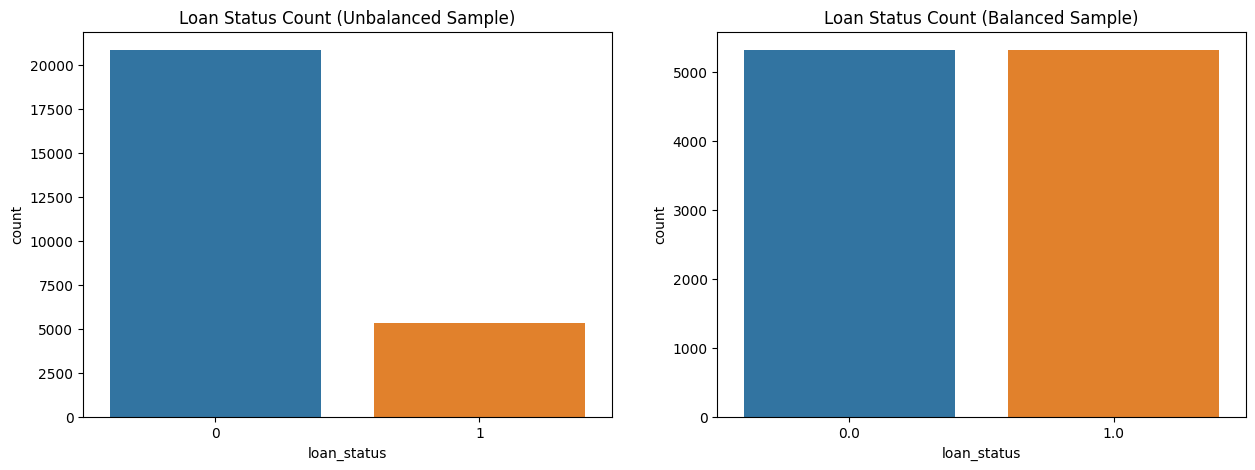

In [70]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

sns.countplot(data=ds, x='loan_status', ax=ax1)
ax1.set_title('Loan Status Count (Unbalanced Sample)')

sns.countplot(data=balanced_ds, x='loan_status', ax=ax2)
ax2.set_title('Loan Status Count (Balanced Sample)')

plt.savefig('Loan status count.png')
plt.show()

### Class Imbalance

- There is a large class imbalance. There are more non defaults 
- An sample number equal to the number of defaults will be taken from the non defaults

In [25]:
defaulters = ds[ds['loan_status'] == 1]
nondefaulters = ds[ds['loan_status'] == 0]

nondefaulters = nondefaulters.sample(n=len(defaulters), random_state=SEED)

balanced_ds = pd.concat([defaulters, nondefaulters])

balanced_ds = balanced_ds.sample(frac=1, random_state=SEED)

balanced_ds = balanced_ds.reset_index(drop=True)

del defaulters, nondefaulters

In [26]:
balanced_ds.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,25,75000,MORTGAGE,5.0,EDUCATION,5800,NaN,0,0.08,N,2
1,29,45000,MORTGAGE,4.0,PERSONAL,15000,18.49,0,0.33,N,6
2,34,50000,RENT,4.0,PERSONAL,18000,8.88,1,0.36,N,9
3,26,46800,RENT,6.0,DEBTCONSOLIDATION,7500,9.99,0,0.16,N,3
4,21,37000,RENT,0.0,PERSONAL,4000,10.08,0,0.11,N,3


In [27]:
cat_cols = list(balanced_ds.select_dtypes(exclude='number').columns)
enc = {}

for col in cat_cols:
    le = LabelEncoder()
    balanced_ds[col] = le.fit_transform(balanced_ds[col])
    enc[col] = le

In [28]:
balanced_ds.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              371
loan_intent                      0
loan_amnt                        0
loan_int_rate                 1029
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [29]:
imputer = KNNImputer()

balanced_ds[balanced_ds.columns] = imputer.fit_transform(balanced_ds.values)

In [30]:
balanced_ds.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,25.0,75000.0,0.0,5.0,1.0,5800.0,8.792,0.0,0.08,0.0,2.0
1,29.0,45000.0,0.0,4.0,4.0,15000.0,18.490,0.0,0.33,0.0,6.0
2,34.0,50000.0,3.0,4.0,4.0,18000.0,8.880,1.0,0.36,0.0,9.0
3,26.0,46800.0,3.0,6.0,0.0,7500.0,9.990,0.0,0.16,0.0,3.0
4,21.0,37000.0,3.0,0.0,4.0,4000.0,10.080,0.0,0.11,0.0,3.0


In [31]:
scaler = StandardScaler()

In [32]:
x = balanced_ds.drop('loan_status', axis=1).values
x_scaled = scaler.fit_transform(x)
y = balanced_ds['loan_status'].values

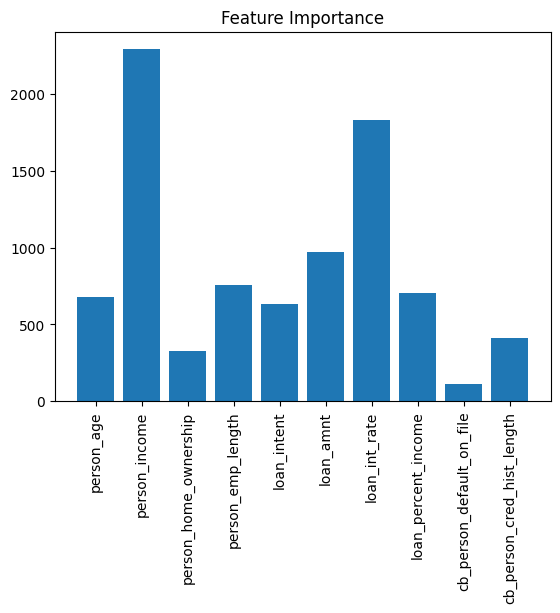

In [81]:
lgbm = LGBMClassifier(n_estimators=300, max_depth=7, learning_rate=0.1, verbose=-1, random_state=SEED)

lgbm.fit(x,y)

plt.bar(balanced_ds.drop('loan_status', axis=1).columns, lgbm.feature_importances_)
plt.xticks(rotation=90)
plt.title('Feature Importance')
plt.savefig('Feature Importance.png')
plt.show()

### Feature Importance

- Income is the most important feature according to the model.
- Loan Interest Rate is the second most important feature.
- Loan Amount, Person Employment Length and Loan/Income % complete the top 5
- Possessing a default on record is the least useful feature

In [82]:
print(list(zip(balanced_ds.drop('loan_status', axis=1).columns, lgbm.feature_importances_)))

[('person_age', 677), ('person_income', 2290), ('person_home_ownership', 329), ('person_emp_length', 758), ('loan_intent', 635), ('loan_amnt', 968), ('loan_int_rate', 1833), ('loan_percent_income', 705), ('cb_person_default_on_file', 112), ('cb_person_cred_hist_length', 410)]


In [33]:
lgbm = LGBMClassifier(n_estimators=300, max_depth=7, learning_rate=0.1, verbose=-1, random_state=SEED)
cat = CatBoostClassifier(depth=6, iterations=1000, verbose=0, random_state=SEED)
xgb = XGBClassifier(n_estimators=150, max_depth=7, random_state=SEED)
rfc = RandomForestClassifier(n_estimators=150, max_depth=10, random_state=SEED)
gbc = GradientBoostingClassifier(n_estimators=150, learning_rate=0.05, random_state=SEED)
dtc = DecisionTreeClassifier(max_depth=8, criterion='entropy', random_state=SEED)

est = [
    ('LGBM', lgbm),
    ('CatBoost', cat),
    ('XGBoost', xgb),
    ('RandomForest', rfc),
    ('GradientBoosting', gbc),
    ('DecisionTree', dtc),
]

stc = StackingClassifier(est)

all_est = [*est, ('Stacking', stc)]

In [34]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

In [35]:
all_scores = []

for name, model in all_est:
    if name == 'KNeighbors':
        scores = cross_val_score(model, x_scaled, y, scoring = 'roc_auc', cv = cv)
    else:
        scores = cross_val_score(model, x, y, scoring = 'roc_auc', cv = cv)
    
    all_scores.append((name, np.mean(scores)))

In [36]:
predictor = TabularPredictor(label='loan_status', eval_metric='roc_auc').fit(train_data=balanced_ds, time_limit=3600, num_bag_folds=5)

leaderboard_df = predictor.leaderboard(silent=True)

all_scores.append(('AutoGulon', leaderboard_df['score_val'][0]))

No path specified. Models will be saved in: "AutogluonModels/ag-20240911_191504"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Jun 27 20:43:36 UTC 2024
CPU Count:          4
Memory Avail:       29.78 GB / 31.36 GB (95.0%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time

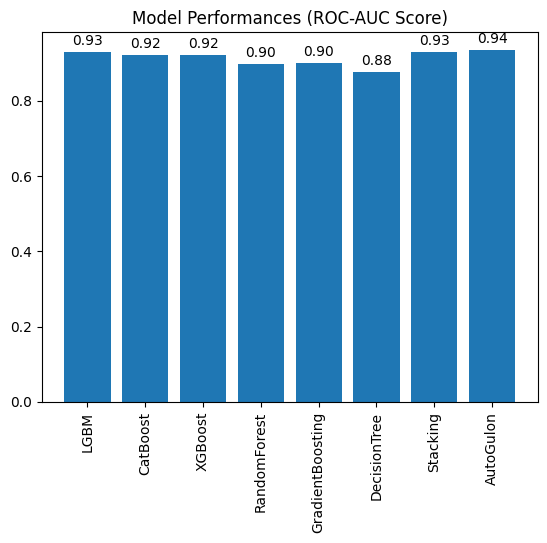

In [44]:
names = [name for name, _ in all_scores]
scores = [score for _, score in all_scores]

plt.bar(names, scores)
plt.xticks(rotation=90)
plt.title('Model Performances (ROC-AUC Score)')

for i, score in enumerate(scores):
    plt.text(i, score + 0.01, f'{score:.2f}', ha='center', va='bottom')

plt.savefig("Model performance.png")
plt.show()

### Model Performance

- The best model performance was recored by the AutoGulon model
- Followed closely by the LGBM model and the ensemble Stacking model.
- The Decision Tree model recorded the lowest score, but even that score was higher then the target metric we set out to achieve.